<a href="https://colab.research.google.com/github/Amna1701/alfaisalx-medmnist-challenge/blob/main/AlfaisalX_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlfaisalX Postdoctoral Technical Challenge
PneumoniaMNIST – End-to-End System Demonstration

In [2]:
!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
%cd alfaisalx-medmnist-challenge
!ls

Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 139 (delta 44), reused 36 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 2.99 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/alfaisalx-medmnist-challenge
data	notebooks  reports	     Task_3.ipynb
models	README.md  requirements.txt  task3_retrieval


# Task 1 – CNN Classification on PneumoniaMNIST

This notebook implements a lightweight convolutional neural network (CNN)
for binary classification of chest X-ray images (Normal vs Pneumonia)
using the MedMNIST v2 PneumoniaMNIST dataset.

The implementation runs on CPU and reproduces evaluation metrics,
saves training curves, confusion matrix, ROC curve, failure cases,
and Grad-CAM visualizations under:

reports/task1/

## Environment Setup

In [ ]:
!pip install medmnist torch torchvision scikit-learn tqdm faiss-cpu timm transformers -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from medmnist import PneumoniaMNIST
from torchvision import transforms

# Basic transforms (no augmentation yet)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load splits
train_ds = PneumoniaMNIST(split="train", download=True, transform=transform)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=transform)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=transform)

print("Train:", len(train_ds), " Val:", len(val_ds), " Test:", len(test_ds))
print("Example item shapes:")
x, y = train_ds[0]
print("Image tensor shape:", x.shape, " Label:", y, " Label type:", type(y))

Train: 4708  Val: 524  Test: 624
Example item shapes:
Image tensor shape: torch.Size([1, 28, 28])  Label: [1]  Label type: <class 'numpy.ndarray'>


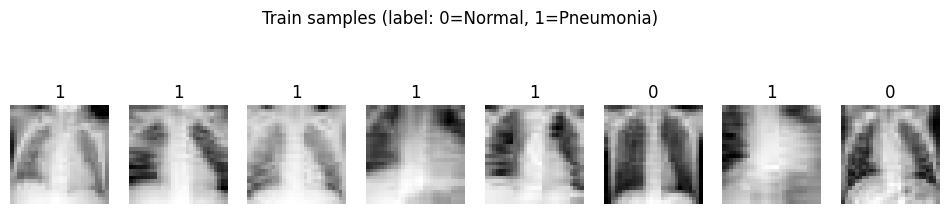

In [ ]:
def show_samples(dataset, n=8, title="Samples"):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        x, y = dataset[i]
        img = x.squeeze(0).numpy()  # (28,28)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(int(y[0]))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, n=8, title="Train samples (label: 0=Normal, 1=Pneumonia)")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = PneumoniaMNIST(split="train", download=True, transform=train_tf)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=test_tf)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=test_tf)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(37, 5, 5)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)  # output logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)  # (B,)

model = SmallCNN().to(device)
print(model)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def run_train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)  # (B,)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def run_val_epoch(model, loader):
    model.eval()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

epochs = 15
train_losses, val_losses = [], []
best_val = float("inf")
best_path = "best_model_task1.pt"

for epoch in range(1, epochs+1):
    tr_loss = run_train_epoch(model, train_loader)
    va_loss = run_val_epoch(model, val_loader)
    scheduler.step(va_loss)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), best_path)

print("Best model saved to:", best_path, "best_val_loss:", best_val)

  0%|          | 0/37 [00:00<?, ?it/s]/tmp/ipython-input-2846689616.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)  # (B,)
/tmp/ipython-input-2846689616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)


Epoch 01 | train_loss=0.5876 | val_loss=0.5592


Epoch 02 | train_loss=0.5090 | val_loss=0.4366


Epoch 03 | train_loss=0.3631 | val_loss=0.3180


Epoch 04 | train_loss=0.2502 | val_loss=0.2835


Epoch 05 | train_loss=0.2307 | val_loss=0.2323


Epoch 06 | train_loss=0.2097 | val_loss=0.2099


Epoch 07 | train_loss=0.2097 | val_loss=0.2089


Epoch 08 | train_loss=0.1889 | val_loss=0.2009


Epoch 09 | train_loss=0.1838 | val_loss=0.2218


Epoch 10 | train_loss=0.1774 | val_loss=0.1832


Epoch 11 | train_loss=0.1724 | val_loss=0.1853


Epoch 12 | train_loss=0.1704 | val_loss=0.1896


Epoch 13 | train_loss=0.1542 | val_loss=0.1593


Epoch 14 | train_loss=0.1538 | val_loss=0.1557


Epoch 15 | train_loss=0.1520 | val_loss=0.1765
Best model saved to: best_model_task1.pt best_val_loss: 0.1557475301714344


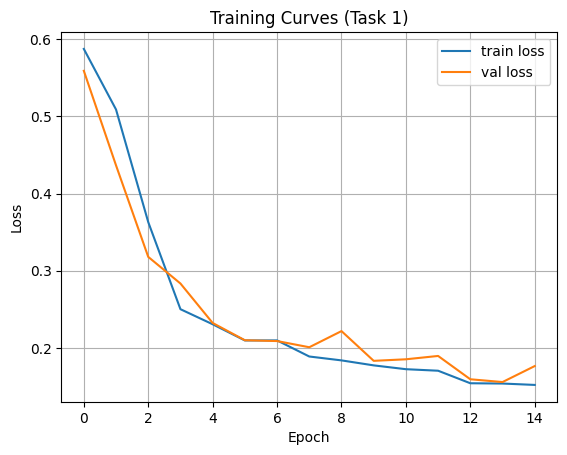

In [ ]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("best_model_task1.pt"))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predictions
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("AUC      :", auc)

Accuracy : 0.8942307692307693
Precision: 0.8802816901408451
Recall   : 0.9615384615384616
F1-score : 0.9191176470588235
AUC      : 0.950635546789393


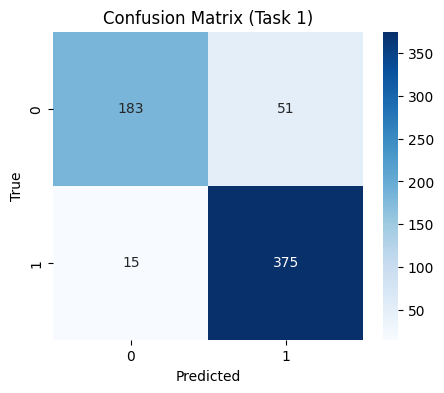

In [ ]:
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.show()

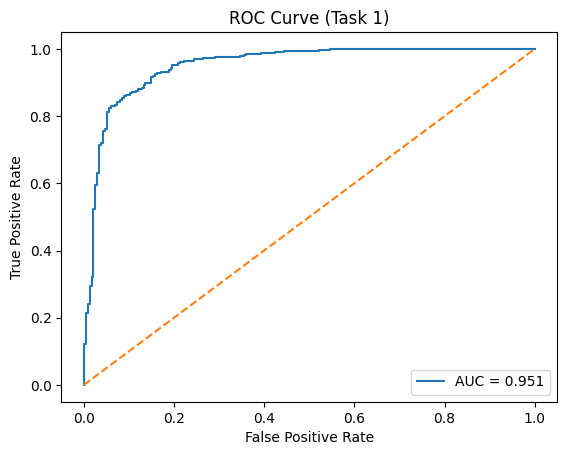

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.show()

In [ ]:
wrong_indices = np.where(preds != all_labels)[0]
len(wrong_indices)

66

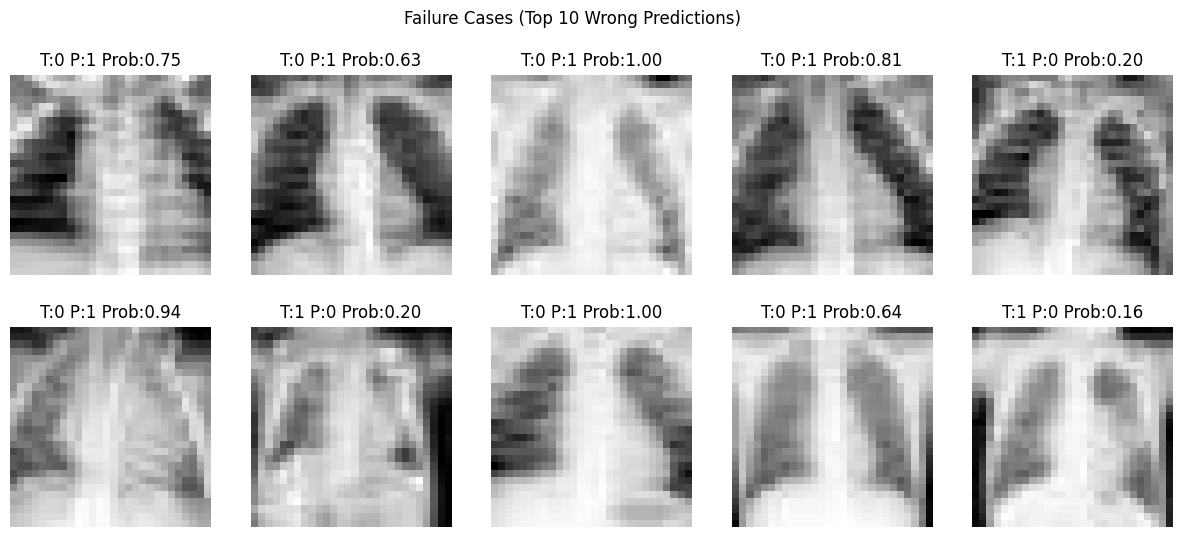

In [ ]:
# Get original (non-augmented) test dataset for visualization
orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))

for i in range(10):  # show 10 wrong cases
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.show()

In [ ]:
import os

os.makedirs("reports/task1", exist_ok=True)

# Save training curves
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.savefig("reports/task1/training_curves.png", dpi=300)
plt.close()

# Save confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.savefig("reports/task1/confusion_matrix.png", dpi=300)
plt.close()

# Save ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.savefig("reports/task1/roc_curve.png", dpi=300)
plt.close()

print("All figures saved in reports/task1/")

All figures saved in reports/task1/


In [ ]:
import json

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "auc": float(auc)
}

with open("reports/task1/test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

metrics

{'accuracy': 0.8942307692307693,
 'precision': 0.8802816901408451,
 'recall': 0.9615384615384616,
 'f1_score': 0.9191176470588235,
 'auc': 0.950635546789393}

In [ ]:
plt.figure(figsize=(15,6))

for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()

print("Failure cases saved.")

Failure cases saved.


# Task 2 — Report Generation (VLM)

In [ ]:
!pip -q install medmnist transformers accelerate sentencepiece pillow timm

import os, random
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
from medmnist import PneumoniaMNIST
from transformers import BlipProcessor, BlipForConditionalGeneration

print("All imports successful")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.6 MB/s eta 0:00:00
All imports successful


In [ ]:
import medmnist
print(medmnist.__version__)

3.0.2


In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

MODEL_ID = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(MODEL_ID)
vlm = BlipForConditionalGeneration.from_pretrained(MODEL_ID).to(device)
vlm.eval()

print("BLIP loaded ✅")

Device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

BLIP loaded ✅


In [ ]:
from medmnist import PneumoniaMNIST
from torchvision import transforms
from PIL import Image
import numpy as np

tf = transforms.Compose([transforms.ToTensor()])
test_ds = PneumoniaMNIST(split="test", download=True, transform=tf)

print("Test size:", len(test_ds))

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.37MB/s]


Test size: 624


In [ ]:
@torch.no_grad()
def generate_report(pil_img, prompt="Chest X-ray report:", max_new_tokens=80):
    inputs = processor(images=pil_img, text=prompt, return_tensors="pt").to(device)
    out = vlm.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    return processor.decode(out[0], skip_special_tokens=True).strip()

In [ ]:
import os, random
import pandas as pd

OUT_DIR = "reports/task2"
IMG_DIR = f"{OUT_DIR}/images"
TXT_DIR = f"{OUT_DIR}/text"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(TXT_DIR, exist_ok=True)

# pick 10 examples quickly
indices = random.sample(range(len(test_ds)), 10)

rows = []
for idx in indices:
    x, y = test_ds[idx]
    img = (x.squeeze(0).numpy() * 255).astype(np.uint8)
    pil_img = Image.fromarray(img).convert("RGB")

    label = int(y[0])
    prompt = "You are a radiologist. Write 2 sentences: (1) findings, (2) impression."
    text = generate_report(pil_img, prompt=prompt, max_new_tokens=80)

    img_path = f"{IMG_DIR}/img_{idx}_label_{label}.png"
    txt_path = f"{TXT_DIR}/report_{idx}.txt"

    pil_img.save(img_path)
    with open(txt_path, "w") as f:
        f.write(text)

    rows.append({"index": idx, "true_label": label, "prompt": prompt, "generated_report": text})

df = pd.DataFrame(rows)
df.to_csv(f"{OUT_DIR}/generated_reports.csv", index=False)

print("✅ Saved Task2 outputs to:", OUT_DIR)
df.head()

✅ Saved Task2 outputs to: reports/task2


,index,true_label,prompt,generated_report
0,25,0,You are a radiologist. Write 2 sentences: (1) ...,you are a radiologist. write 2 sentences : ( 1...
1,303,1,You are a radiologist. Write 2 sentences: (1) ...,you are a radiologist. write 2 sentences : ( 1...
2,135,1,You are a radiologist. Write 2 sentences: (1) ...,you are a radiologist. write 2 sentences : ( 1...
3,606,0,You are a radiologist. Write 2 sentences: (1) ...,you are a radiologist. write 2 sentences : ( 1...
4,35,1,You are a radiologist. Write 2 sentences: (1) ...,you are a radiologist. write 2 sentences : ( 1...


In [ ]:
import os
print("Task2 files:", len(os.listdir("reports/task2")))
print("Images:", len(os.listdir("reports/task2/images")))
print("Texts:", len(os.listdir("reports/task2/text")))

Task2 files: 3
Images: 10
Texts: 10


In [ ]:
%cd /content
!ls

/content
reports  sample_data


In [ ]:
%cd /content/alfaisalx-medmnist-challenge
!ls -la

/content/alfaisalx-medmnist-challenge
total 48
drwxr-xr-x 8 root root 4096 Feb 22 16:08 .
drwxr-xr-x 1 root root 4096 Feb 22 16:08 ..
drwxr-xr-x 2 root root 4096 Feb 22 16:08 data
drwxr-xr-x 8 root root 4096 Feb 22 16:08 .git
-rw-r--r-- 1 root root 4688 Feb 22 16:08 .gitignore
drwxr-xr-x 2 root root 4096 Feb 22 16:08 models
drwxr-xr-x 2 root root 4096 Feb 22 16:08 notebooks
-rw-r--r-- 1 root root 1559 Feb 22 16:08 README.md
drwxr-xr-x 4 root root 4096 Feb 22 16:08 reports
-rw-r--r-- 1 root root   69 Feb 22 16:08 requirements.txt
drwxr-xr-x 2 root root 4096 Feb 22 16:08 task3_retrieval


In [ ]:
!mkdir -p reports
!cp -r /content/reports/task2 reports/

In [ ]:
!find reports/task2 -maxdepth 2 -type f

reports/task2/images/img_513_label_1.png
reports/task2/images/img_157_label_1.png
reports/task2/images/img_606_label_0.png
reports/task2/images/img_29_label_1.png
reports/task2/images/img_86_label_0.png
reports/task2/images/img_135_label_1.png
reports/task2/images/img_303_label_1.png
reports/task2/images/img_35_label_1.png
reports/task2/images/img_25_label_0.png
reports/task2/images/img_3_label_0.png
reports/task2/generated_reports.csv
reports/task2/text/report_303.txt
reports/task2/text/report_29.txt
reports/task2/text/report_135.txt
reports/task2/text/report_157.txt
reports/task2/text/report_35.txt
reports/task2/text/report_86.txt
reports/task2/text/report_25.txt
reports/task2/text/report_606.txt
reports/task2/text/report_513.txt
reports/task2/text/report_3.txt


In [ ]:
!git add -A
!git commit -m "Add Task2 report generation outputs"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@74613efb4f95.(none)')


In [ ]:
%cd /content/alfaisalx-medmnist-challenge

!git config --global user.name "Amna1701"
!git config --global user.email "2018024900@chd.edu.cn"

!git config --global --list | head -n 20

/content/alfaisalx-medmnist-challenge
user.name=Amna1701
user.email=2018024900@chd.edu.cn


In [ ]:
!git add -A
!git commit -m "Add Task2 report generation outputs"

[main edf9912] Add Task2 report generation outputs
 21 files changed, 21 insertions(+)
 create mode 100644 reports/task2/generated_reports.csv
 create mode 100644 reports/task2/images/img_135_label_1.png
 create mode 100644 reports/task2/images/img_157_label_1.png
 create mode 100644 reports/task2/images/img_25_label_0.png
 create mode 100644 reports/task2/images/img_29_label_1.png
 create mode 100644 reports/task2/images/img_303_label_1.png
 create mode 100644 reports/task2/images/img_35_label_1.png
 create mode 100644 reports/task2/images/img_3_label_0.png
 create mode 100644 reports/task2/images/img_513_label_1.png
 create mode 100644 reports/task2/images/img_606_label_0.png
 create mode 100644 reports/task2/images/img_86_label_0.png
 create mode 100644 reports/task2/text/report_135.txt
 create mode 100644 reports/task2/text/report_157.txt
 create mode 100644 reports/task2/text/report_25.txt
 create mode 100644 reports/task2/text/report_29.txt
 create mode 100644 reports/task2/text/

In [ ]:
%cd /content/alfaisalx-medmnist-challenge
!git status

/content/alfaisalx-medmnist-challenge
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
%cd /content/alfaisalx-medmnist-challenge
!git remote set-url origin https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
!git add -A
!git commit -m "Remove token cells"
!git push

/content/alfaisalx-medmnist-challenge
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
%cd /content/alfaisalx-medmnist-challenge

# copy your task2 outputs into the repo
!mkdir -p reports
!cp -r /content/reports/task2 reports/

# confirm files
!find reports/task2 -maxdepth 2 -type f | head
!ls reports/task2/images | wc -l
!ls reports/task2/text | wc -l

# commit + push
!git add -A
!git commit -m "Add Task2 report generation outputs"
!git push

/content/alfaisalx-medmnist-challenge
reports/task2/images/img_513_label_1.png
reports/task2/images/img_157_label_1.png
reports/task2/images/img_606_label_0.png
reports/task2/images/img_29_label_1.png
reports/task2/images/img_86_label_0.png
reports/task2/images/img_135_label_1.png
reports/task2/images/img_303_label_1.png
reports/task2/images/img_35_label_1.png
reports/task2/images/img_25_label_0.png
reports/task2/images/img_3_label_0.png
10
10
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!pip -q install medmnist timm pillow
!pip -q install faiss-cpu || echo "FAISS install failed. We'll use sklearn fallback."
!pip -q install scikit-learn

import os, json, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

print("✅ Installed & imports OK")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 68.2 MB/s eta 0:00:00
✅ Installed & imports OK


In [ ]:
from medmnist import PneumoniaMNIST

# PneumoniaMNIST is 28x28 grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # make 3-channel for ResNet
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

test_ds = PneumoniaMNIST(split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)

print("✅ Test size:", len(test_ds))

100%|██████████| 4.17M/4.17M [00:00<00:00, 4.59MB/s]


✅ Test size: 624


In [ ]:
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Use ResNet18 (pretrained) as a stable embedding extractor
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Identity()  # output = 512-d embeddings
resnet = resnet.to(device)
resnet.eval()

print("✅ ResNet18 embedding model ready")

Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]

✅ ResNet18 embedding model ready


In [ ]:
@torch.no_grad()
def extract_embeddings(loader, model, device):
    all_emb, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        emb = model(x)  # (B, 512)
        emb = emb.detach().cpu().numpy()
        all_emb.append(emb)
        all_y.append(y.numpy().reshape(-1))  # shape (B,)
    E = np.vstack(all_emb).astype("float32")
    Y = np.concatenate(all_y).astype("int64")
    return E, Y

E_test, y_test = extract_embeddings(test_loader, resnet, device)
print("✅ Embeddings:", E_test.shape, " Labels:", y_test.shape)

✅ Embeddings: (624, 512)  Labels: (624,)


In [ ]:
use_faiss = False
index = None

try:
    import faiss
    use_faiss = True
    dim = E_test.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(E_test)
    print("✅ FAISS index built. Vectors:", index.ntotal)
except Exception as e:
    print("⚠️ FAISS not available, using sklearn fallback.")
    use_faiss = False

✅ FAISS index built. Vectors: 624


In [ ]:
from sklearn.neighbors import NearestNeighbors

Ks = [1, 3, 5, 10]

def precision_at_k(retrieved_labels, true_label):
    return (retrieved_labels == true_label).mean()

# Build sklearn NN index if FAISS not used
if not use_faiss:
    nn_index = NearestNeighbors(n_neighbors=max(Ks)+1, metric="euclidean")
    nn_index.fit(E_test)

precisions = {f"P@{k}": [] for k in Ks}

for i in range(len(test_ds)):
    q = E_test[i:i+1]  # (1, dim)
    true = y_test[i]

    if use_faiss:
        D, I = index.search(q, max(Ks)+1)  # includes itself
        idxs = I[0]
    else:
        distances, idxs = nn_index.kneighbors(q, n_neighbors=max(Ks)+1, return_distance=True)
        idxs = idxs[0]

    # remove self (first item usually is itself)
    idxs = [j for j in idxs if j != i]

    for k in Ks:
        topk = idxs[:k]
        retrieved = y_test[topk]
        precisions[f"P@{k}"].append(precision_at_k(retrieved, true))

metrics = {k: float(np.mean(v)) for k, v in precisions.items()}
metrics["N_test"] = int(len(test_ds))
metrics["embedding_dim"] = int(E_test.shape[1])
metrics["index"] = "faiss" if use_faiss else "sklearn"

print("✅ Retrieval Metrics:", metrics)

✅ Retrieval Metrics: {'P@1': 0.8637820512820513, 'P@3': 0.8536324786324786, 'P@5': 0.8451923076923077, 'P@10': 0.8299679487179487, 'N_test': 624, 'embedding_dim': 512, 'index': 'faiss'}


In [ ]:
OUT_DIR = "reports/task3"
os.makedirs(OUT_DIR, exist_ok=True)

# Save arrays
np.save(f"{OUT_DIR}/embeddings_test.npy", E_test)
np.save(f"{OUT_DIR}/labels_test.npy", y_test)

# Save metrics
with open(f"{OUT_DIR}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Save FAISS index if used
if use_faiss:
    import faiss
    faiss.write_index(index, f"{OUT_DIR}/index.faiss")

print(f"✅ Saved Task3 outputs to: {OUT_DIR}")
!ls -lah reports/task3

✅ Saved Task3 outputs to: reports/task3
total 2.5M
drwxr-xr-x 2 root root 4.0K Feb 22 17:38 .
drwxr-xr-x 3 root root 4.0K Feb 22 17:38 ..
-rw-r--r-- 1 root root 1.3M Feb 22 17:38 embeddings_test.npy
-rw-r--r-- 1 root root 1.3M Feb 22 17:38 index.faiss
-rw-r--r-- 1 root root 5.0K Feb 22 17:38 labels_test.npy
-rw-r--r-- 1 root root  180 Feb 22 17:38 metrics.json


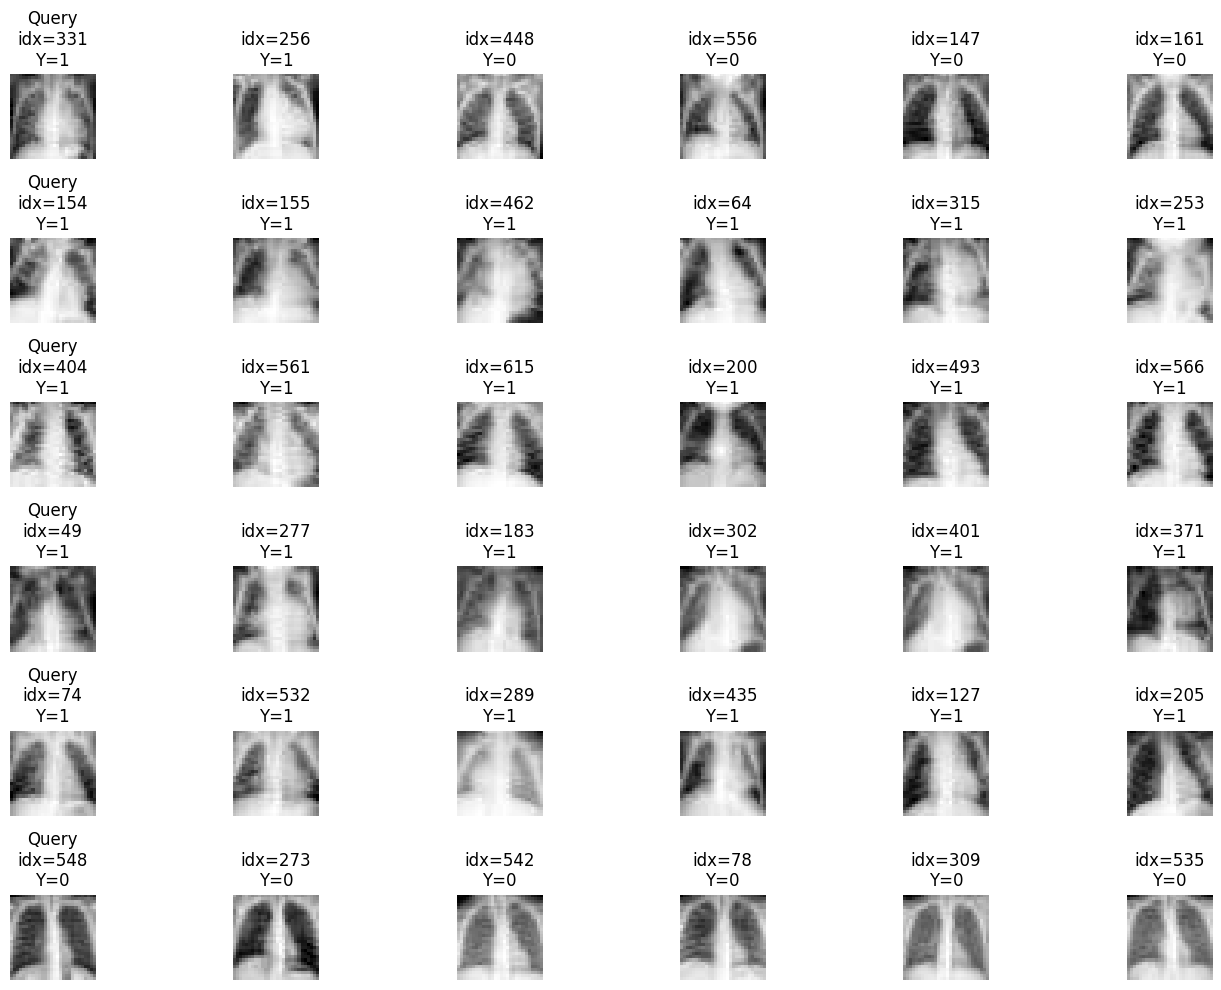

✅ Saved: reports/task3/retrieval_examples.png


In [ ]:
# Helper to load original 28x28 image for display (clean and correct)
raw_ds = PneumoniaMNIST(split="test", download=True, transform=None)

def get_raw_pil(i):
    img, y = raw_ds[i]
    # img is numpy array (28,28) or (28,28,1)
    img = np.array(img).squeeze().astype(np.uint8)
    return Image.fromarray(img), int(np.array(y).reshape(-1)[0])

def retrieve(i, k=5):
    q = E_test[i:i+1]
    if use_faiss:
        D, I = index.search(q, k+1)
        idxs = [j for j in I[0] if j != i][:k]
    else:
        distances, idxs = nn_index.kneighbors(q, n_neighbors=k+1)
        idxs = [j for j in idxs[0] if j != i][:k]
    return idxs

random.seed(7)
example_ids = random.sample(range(len(test_ds)), 6)

fig = plt.figure(figsize=(14, 10))
plot_idx = 1

for qi in example_ids:
    qimg, qy = get_raw_pil(qi)
    topk = retrieve(qi, k=5)

    # Query
    ax = plt.subplot(len(example_ids), 6, plot_idx)
    ax.imshow(qimg, cmap="gray")
    ax.set_title(f"Query\nidx={qi}\nY={qy}")
    ax.axis("off")
    plot_idx += 1

    # Retrieved
    for rj in topk:
        rimg, ry = get_raw_pil(rj)
        ax = plt.subplot(len(example_ids), 6, plot_idx)
        ax.imshow(rimg, cmap="gray")
        ax.set_title(f"idx={rj}\nY={ry}")
        ax.axis("off")
        plot_idx += 1

plt.tight_layout()
plt.savefig("reports/task3/retrieval_examples.png", dpi=200)
plt.show()

print("✅ Saved: reports/task3/retrieval_examples.png")

In [ ]:
html_path = "reports/task3/retrieval_examples.html"
with open(html_path, "w") as f:
    f.write("<h2>Task 3 Retrieval Examples</h2>")
    f.write("<p>Query + Top-5 nearest neighbors (ResNet18 embeddings)</p>")
    f.write('<img src="retrieval_examples.png" style="max-width:100%;height:auto;">')

print("✅ Saved:", html_path)

✅ Saved: reports/task3/retrieval_examples.html


In [ ]:
%cd /content
!rm -rf alfaisalx-medmnist-challenge

!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
%cd /content/alfaisalx-medmnist-challenge
!ls

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 120 (delta 40), reused 27 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 1.58 MiB | 12.32 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/alfaisalx-medmnist-challenge
data  models  notebooks  README.md  reports  requirements.txt  task3_retrieval


In [ ]:
!mkdir -p reports
!cp -r /content/reports/task3 reports/
!find reports/task3 -maxdepth 2 -type f

reports/task3/retrieval_examples.html
reports/task3/labels_test.npy
reports/task3/embeddings_test.npy
reports/task3/retrieval_examples.png
reports/task3/metrics.json
reports/task3/index.faiss


In [ ]:
!git config --global user.name "Amna1701"
!git config --global user.email "2018024900@chd.edu.cn"
!git config --global --list | head -n 20

user.name=Amna1701
user.email=2018024900@chd.edu.cn


In [ ]:
!git add -A
!git status
!git commit -m "Add Task3 retrieval outputs (embeddings + metrics + examples)" || echo "Nothing to commit"

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   reports/task3/embeddings_test.npy
	new file:   reports/task3/index.faiss
	new file:   reports/task3/labels_test.npy
	new file:   reports/task3/metrics.json
	new file:   reports/task3/retrieval_examples.html
	new file:   reports/task3/retrieval_examples.png

[main c60684d] Add Task3 retrieval outputs (embeddings + metrics + examples)
 6 files changed, 10 insertions(+)
 create mode 100644 reports/task3/embeddings_test.npy
 create mode 100644 reports/task3/index.faiss
 create mode 100644 reports/task3/labels_test.npy
 create mode 100644 reports/task3/metrics.json
 create mode 100644 reports/task3/retrieval_examples.html
 create mode 100644 reports/task3/retrieval_examples.png


In [ ]:
!git remote set-url origin https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
!git remote -v

origin	https://github.com/Amna1701/alfaisalx-medmnist-challenge.git (fetch)
origin	https://github.com/Amna1701/alfaisalx-medmnist-challenge.git (push)


In [ ]:
%cd /content
!rm -rf alfaisalx-medmnist-challenge
!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
%cd alfaisalx-medmnist-challenge
!ls

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 123 (delta 40), reused 27 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 1.68 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/alfaisalx-medmnist-challenge
data	notebooks  reports	     Task_3.ipynb
models	README.md  requirements.txt  task3_retrieval


In [ ]:
!rm -rf task3_retrieval

In [ ]:
!cp -r /content/reports/task3 task3_retrieval
!find task3_retrieval -maxdepth 2 -type f

task3_retrieval/retrieval_examples.html
task3_retrieval/labels_test.npy
task3_retrieval/embeddings_test.npy
task3_retrieval/retrieval_examples.png
task3_retrieval/metrics.json
task3_retrieval/index.faiss


In [ ]:
!git config --global user.name "Amna1701"
!git config --global user.email "2018024900@chd.edu.cn"

In [ ]:
!git add -A
!git status
!git commit -m "Add Task3 retrieval results (embeddings + metrics + visualization)"

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   task3_retrieval/embeddings_test.npy
	new file:   task3_retrieval/index.faiss
	new file:   task3_retrieval/labels_test.npy
	new file:   task3_retrieval/metrics.json
	deleted:    task3_retrieval/placeholder.txt
	new file:   task3_retrieval/retrieval_examples.html
	new file:   task3_retrieval/retrieval_examples.png

[main fb40e06] Add Task3 retrieval results (embeddings + metrics + visualization)
 7 files changed, 10 insertions(+), 1 deletion(-)
 create mode 100644 task3_retrieval/embeddings_test.npy
 create mode 100644 task3_retrieval/index.faiss
 create mode 100644 task3_retrieval/labels_test.npy
 create mode 100644 task3_retrieval/metrics.json
 delete mode 100644 task3_retrieval/placeholder.txt
 create mode 100644 task3_retrieval/retrieval_examples.html
 create mode 100644 task3_retrieval/retrieval_examples.png


In [ ]:
!git remote set-url origin https://github.com/Amna1701/alfaisalx-medmnist-challenge.git